In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

tf.config.run_functions_eagerly(False)

2024-04-23 06:24:38.119034: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 06:24:38.167553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 06:24:38.167581: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 06:24:38.167632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 06:24:38.176596: I tensorflow/core/platform/cpu_feature_g

In [2]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Conv2D(128, (3, 3), use_bias=True, activation="leaky_relu"),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          1000, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [3]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          1000, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          6400, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 100)),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.UpSampling2D((2, 2)),
      tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='leaky_relu', use_bias=True, padding='same'),
      tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='leaky_relu', use_bias=True, padding='same')
  ], name="synthesis_transform")


In [4]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for ."""

  def __init__(self, latent_dims, target_rate, target_distortion):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))
    self.target_rate = target_rate
    self.target_distortion = target_distortion

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
  
    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per 64x64 patch
    rate = tf.reduce_mean(rate)

    # Mean squared difference across pixels.
    distortion = tf.reduce_mean(tf.square(x - x_tilde))

    rate = tf.abs((rate / (64 * 64)) - self.target_rate)

    return dict(rate=rate, distortion=distortion)


In [5]:
training_dataset, validation_dataset = tfds.load(
    "imagenet_resized/64x64",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

2024-04-23 06:24:43.558137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 06:24:43.643102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 06:24:43.646297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make__compression_trainer(target_rate, target_distortion, lmbda,  latent_dims=150):
  trainer = CompressionTrainer(latent_dims, target_rate, target_distortion)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [7]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=1., distortion=0.)

def preprocess(image, label):
  image = tf.cast(image, tf.float32) / 255.
  image = tf.image.rgb_to_yuv(image)
  return image, label

def train__model(lmbda, target_rate, target_distortion):
  trainer = make__compression_trainer(target_rate, target_distortion, lmbda)
  trainer.build((256, 64, 64,3))
  trainer.summary()
  history = trainer.fit(
      training_dataset.map(preprocess).map(add_rd_targets).batch(256).prefetch(8),
      epochs=20,
      verbose=1,
      use_multiprocessing=True,
      workers=2
  )
  
  return trainer, history

trainer, history = train__model(lmbda=10000, target_rate=0.5, target_distortion=0)


Model: "compression_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 analysis_transform (Sequen  (256, 150)                6646382   
 tial)                                                           
                                                                 
 synthesis_transform (Seque  (256, 64, 64, 3)          6895835   
 ntial)                                                          
                                                                 
Total params: 13542367 (51.66 MB)
Trainable params: 13542367 (51.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


2024-04-23 06:24:47.595166: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 06:24:47.723694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2024-04-23 06:24:48.113514: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-23 06:24:51.648133: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2ef16df80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 06:24:51.648175: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-23 06:24:51.654013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-23 06:24:51.761514: I ./tensorflow/compiler/jit/device_compiler.h:186] Com

5005/5005 [==============================] - 1119s 221ms/step - loss: 63.4674 - distortion_loss: 0.0063 - rate_loss: 0.1860
Epoch 2/20
5005/5005 [==============================] - 1102s 220ms/step - loss: 42.1240 - distortion_loss: 0.0042 - rate_loss: 0.0061
Epoch 3/20
5005/5005 [==============================] - 1102s 220ms/step - loss: 37.8123 - distortion_loss: 0.0038 - rate_loss: 0.0056
Epoch 4/20
5005/5005 [==============================] - 1100s 220ms/step - loss: 35.8313 - distortion_loss: 0.0036 - rate_loss: 0.0054
Epoch 5/20
5005/5005 [==============================] - 1103s 220ms/step - loss: 34.9018 - distortion_loss: 0.0035 - rate_loss: 0.0050
Epoch 6/20
5005/5005 [==============================] - 1103s 220ms/step - loss: 34.3133 - distortion_loss: 0.0034 - rate_loss: 0.0051
Epoch 7/20
5005/5005 [==============================] - 1102s 220ms/step - loss: 33.8777 - distortion_loss: 0.0034 - rate_loss: 0.0049
Epoch 8/20
5005/5005 [==============================] - 1101s 220m

In [8]:
class Compressor(tf.keras.Model):
  """Compresses  images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [9]:
class Decompressor(tf.keras.Model):
  """Decompresses  images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return x_hat


In [10]:
def make__codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make__codec(trainer)


In [11]:
(originals, _), = validation_dataset.batch(1).take(1)
originals, _ = preprocess(originals, None)

In [12]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Length of string representation : {len(strings[0].numpy().hex())*4}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0xffb291418b9f0524e910104e7e6e71da32fc314dfa1bc462ad5e4b157e618d2282941d5998718192746229ad81f5181035c47bb18ef087dfe544f127a71d2cf68afe05f1316854eaee3d39576b7e13631cbd65fc088b9d9480c67566c984a6873509811ce5adf749a83faaebab01becafed0052eb9ccd3982d9daccf0e200fa1d5a60ea61cfe9ba49f7827d3a89332b19b28eb24a12f70c94d5c8089530667a308ae5c2d2125e55cce855ff7d7733904099c399d0e031fafaaf970a5fbe22ce167931812bc15b3fbe43d1b59de52a82970d5f62d449fbb
Length of string representation : 1720
Number of bits actually needed to represent it: 2211.33


In [13]:
reconstructions = decompressor(strings)
reconstructions = tf.image.yuv_to_rgb(reconstructions)
reconstructions = tf.cast(reconstructions * 255, tf.uint8)

In [14]:
originals = tf.image.yuv_to_rgb(originals)
originals = tf.cast(originals * 255., tf.uint8)

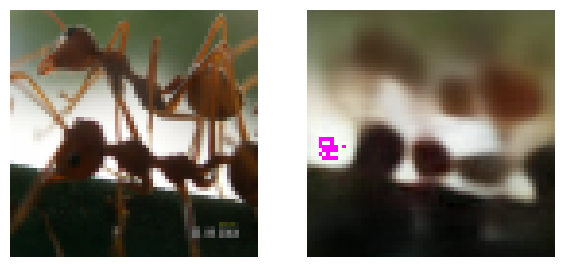

In [15]:
# Display the original and reconstructed images.
plt.figure(figsize=(30, 30))
for i, (original, reconstruction) in enumerate(zip(originals, reconstructions)):
  plt.subplot(4, 8, 2 * i + 1)
  plt.imshow(tf.squeeze(original))
  plt.axis("off")
  plt.subplot(4, 8, 2 * i + 2)
  plt.imshow(tf.squeeze(reconstruction))
  plt.axis("off")

In [16]:
tf.image.ssim(originals, reconstruction, max_val=255)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5690458], dtype=float32)>

In [20]:
import numpy as np
def pad_image(image: np.ndarray, patch_size: int):
 
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='edge'), h_pad, w_pad

In [21]:
def compress_image(image: np.ndarray, compressor, decompressor) -> tuple[np.ndarray, np.ndarray]:
    patch_size = 64

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.reshape(image, [-1, patch_size,patch_size,3])
    image = tf.image.rgb_to_yuv(image)

    strings, entropies = compressor(image)
    reconstructed_patches = decompressor(strings)
    
    reconstructed_image = np.zeros((height, width, channels))

    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].numpy()
            # print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]

    # convert reconstructed image to tensor
    reconstructed_image = tf.convert_to_tensor(reconstructed_image)
    reconstructed_image = tf.image.yuv_to_rgb(reconstructed_image)
    reconstructed_image = tf.cast(reconstructed_image * 255, tf.uint8)
    
    return reconstructed_image, strings

In [22]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')

image_copy = image

result, strings = compress_image(image_copy, compressor, decompressor)

image = tf.cast(image * 255, tf.uint8)

(467, 396, 3)
(467, 396, 3)


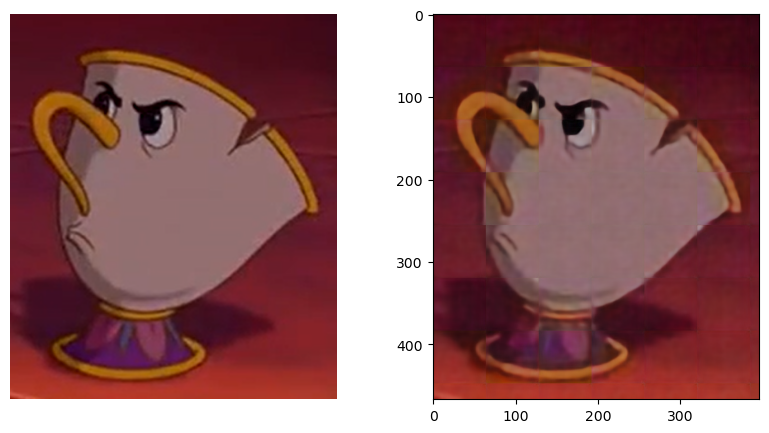

In [23]:
# plot both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(image))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(result))
print(result.shape)
print(image.shape)

In [24]:
tf.image.ssim(image, result, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9028184>

In [25]:
tf.image.ssim_multiscale(image, result, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9240601>

In [26]:
tf.image.psnr(image, result, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=30.52687>

In [27]:
bits = sum([len(strings[i].numpy().hex())*4 for i in range(len(strings))])
print(f"Length of string representation : {bits}")
print(f"Bits per pixel : {bits/(image.shape[0] * image.shape[1])}")

Length of string representation : 74104
Bits per pixel : 0.4007094499599853


In [28]:
trainer.save_weights("models/big_model.h5")

In [29]:
trainer.save("models/big_model")

INFO:tensorflow:Assets written to: models/big_model/assets


INFO:tensorflow:Assets written to: models/big_model/assets
